# Run hacked AlphaFold2 on the MPNN designed binders

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/home/pleung/projects/grad_reqs
running on node: dig103


### Insert the root of the crispy_shifty repo

In [ ]:
sys.path.insert(0, "/global/cfs/cdirs/m4129/projects/crispy_shifty")

### Fix the paths
Necessary because we are on perlmutter

In [ ]:
from crispy_shifty.utils.io import fix_path_prefixes

pairs = os.path.join(os.getcwd(), "01_mpnn_around_ligand/filtered_designed.pair")
new_pairs = fix_path_prefixes(
    find="/mnt/home/pleung/projects",
    replace="/global/u1/p/pleung",
    file=pairs,
    overwrite=True,
)

### Run AF2 on the MPNN designed binders

In [ ]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "02_fold_apo"
design_list_file = os.path.join(
    os.getcwd(), "01_mpnn_around_ligand/filtered_designed.pair"
)

output_path = os.path.join(f"/pscratch/sd/p/pleung/{simulation_name}")

options = " ".join(
    [
        "out:level 200",
        f"extra_res_fa {os.path.join(os.getcwd(), 'afo.params')}",
    ]
)
extra_kwargs = {"models": "4"}

gen_array_tasks(
    distribute_func="deployables.fold_binder",
    func_root="/global/u1/p/pleung/grad_reqs",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    time="24:00",
)

### Collect scorefiles of the folded binders and concatenate

In [2]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "02_fold_apo"
output_path = os.path.join(os.getcwd(), f"{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

https://docs.anaconda.com/anaconda/install



/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

### Dump scores_df as a CSV and then reload, for performance reasons

In [4]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [5]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [6]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"]
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(2000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

In [7]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

5623
['design_type', 'designed_by', 'elapsed_time', 'fa_rmsd', 'mean_pae', 'mean_pae_interaction', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_plddt', 'model', 'pTMscore', 'path_in', 'recycles', 'rmsd_to_reference', 'seed', 'tol', 'total_score', 'type']


In [8]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

### Plot before and after interface design AF2 metrics

4it [00:00, 14.56it/s]


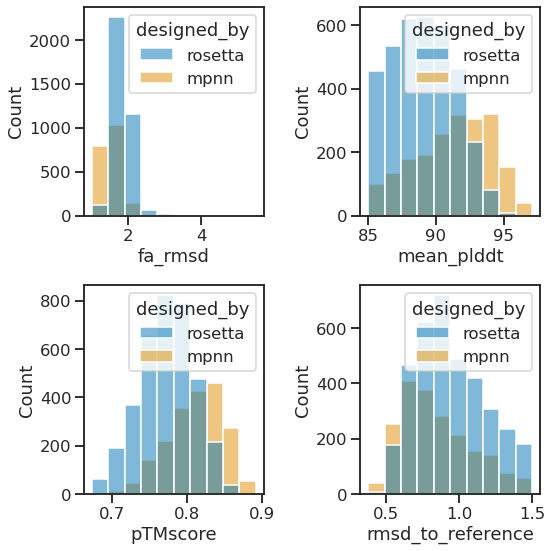

In [9]:
cols = [
    "fa_rmsd",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "af2_scores.png"))

<Figure size 1152x1152 with 0 Axes>

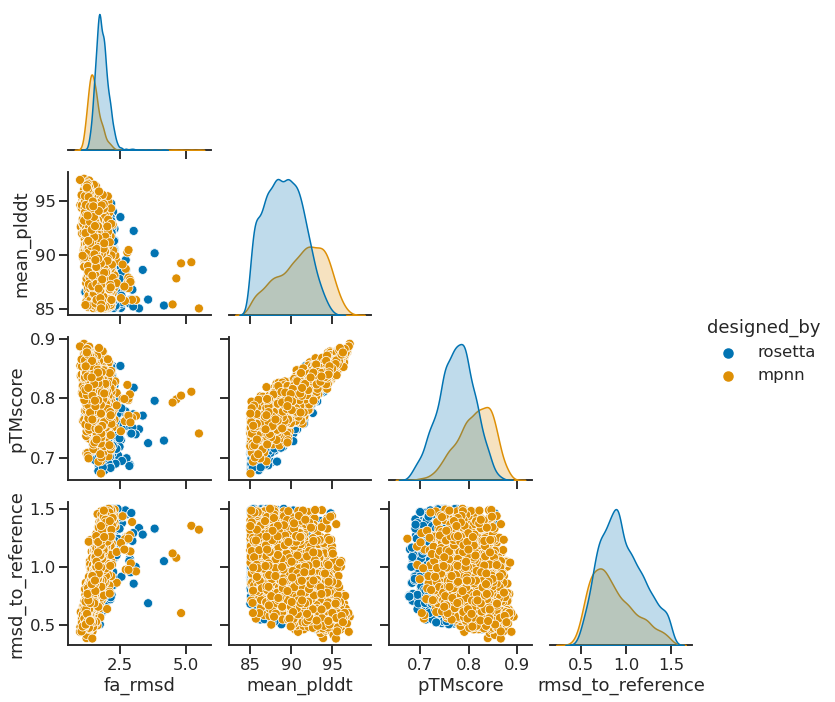

In [10]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "af2_scores_paired.png"))

### Filter the whole df

In [14]:
query = (
    "fa_rmsd < 1.5 and mean_plddt > 93 and pTMscore > 0.85 and rmsd_to_reference < 0.75"
)

filtered = scores_df.query(query)
len(filtered)

71279

### Save a list of outputs
Sort by length  

In [15]:
simulation_name = "02_fold_apo"
output_path = os.path.join(os.getcwd(), f"{simulation_name}")

with open(os.path.join(output_path, "folded.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

  0%|          | 0/71279 [00:00<?, ?it/s]

### Fix the paths
Necessary because we transferred from perlmutter

In [16]:
from crispy_shifty.utils.io import fix_path_prefixes

_ = fix_path_prefixes(
    find="/pscratch/sd/p/pleung",
    replace="/home/pleung/projects/grad_reqs",
    file=os.path.join(output_path, "folded.list"),
    overwrite=True,
)

### Prototyping blocks